# Fast Macro F1 computation

Macro F1 score is used as [evaluation metric](https://www.kaggle.com/c/liverpool-ion-switching/overview/evaluation) for this Liverpool ion switching competition.

Here I will introduce implementation which is **around 10 times faster than [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)**.

In [ ]:
import numba as nb
import numpy as np
import pandas as pd
from sklearn import metrics

from contextlib import contextmanager
from time import perf_counter


@contextmanager
def timer(name):
    t0 = perf_counter()
    yield
    t1 = perf_counter()
    print('[{}] done in {:.3f} s'.format(name, t1-t0))


# Implementation

As written in the [evaluation metric](https://www.kaggle.com/c/liverpool-ion-switching/overview/evaluation) page, macro F1 score is defined as:

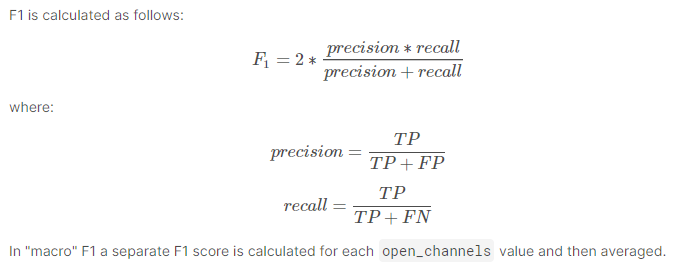


Let's simply implement this equation.

In [ ]:
def macro_f1_score(y_true, y_pred, n_labels):
    total_f1 = 0.
    for i in range(n_labels):
        yt = y_true == i
        yp = y_pred == i

        tp = np.sum(yt & yp)

        tpfp = np.sum(yp)
        tpfn = np.sum(yt)
        if tpfp == 0:
            print('[WARNING] F-score is ill-defined and being set to 0.0 in labels with no predicted samples.')
            precision = 0.
        else:
            precision = tp / tpfp
        if tpfn == 0:
            print(f'[ERROR] label not found in y_true...')
            recall = 0.
        else:
            recall = tp / tpfn

        if precision == 0. or recall == 0.:
            f1 = 0.
        else:
            f1 = 2 * precision * recall / (precision + recall)
        total_f1 += f1
    return total_f1 / n_labels

Also, we can use **[numba](http://numba.pydata.org/)**, which does [JIT (Just In Time compilation)](https://en.wikipedia.org/wiki/Just-in-time_compilation) for further acceleration.

In [ ]:
macro_f1_score_nb = nb.jit(nb.float64(nb.int32[:], nb.int32[:], nb.int64), nopython=True, nogil=True)(macro_f1_score)

# Benchmark

Let's compare the speed for each implementation!

I set `n_class=10` and `datasize=5M`, which match to this competition's training data.

In [ ]:
n_class = 10
datasize = 5_000_000
y_true = np.random.randint(0, n_class, datasize).astype(np.int32)
y_pred = np.random.randint(0, n_class, datasize).astype(np.int32)

In [ ]:
with timer('sklearn'):
    f1_sk = metrics.f1_score(y_true, y_pred, average='macro')
with timer('custom'):
    f1_custom = macro_f1_score(y_true, y_pred, n_class)
with timer('custom numba'):
    f1_custom_nb = macro_f1_score_nb(y_true, y_pred, n_class)

As we can see custom implementation is about **10 times faster!**, also we can get **2 times boost** by using numba version.

Check value is same!

In [ ]:
print('f1_sk', f1_sk, 'f1_custom', f1_custom, 'f1_custom_nb', f1_custom_nb)

# Why we need fast computation?

When you just calculate macro f1 score for training validation, we don't execute computation many times so its profit is not so high.
Its benefit comes when you want to optimize F1 score, as introduced in the discussion by @artgor: [It is easy to change OptimizedRounder to optimize F1](https://www.kaggle.com/c/liverpool-ion-switching/discussion/134138).